In [1]:
import pandas as pd
import numpy as np

from utils import *

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
RESET = True
DATASET = "ALL"
CLASSES = ["happy", "sad", "angry", "neutral"]

## Loading Data

In [3]:
if RESET:
    data_df = load_data(CLASSES, DATASET, "../data/")
else:
    data_df = pd.read_csv(f"../data/{DATASET}_data_path.csv")

## EDA

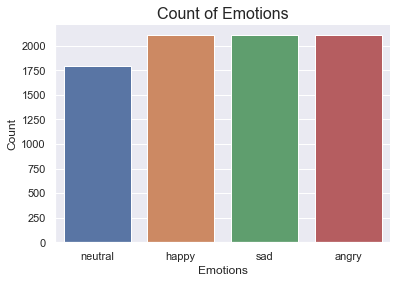

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

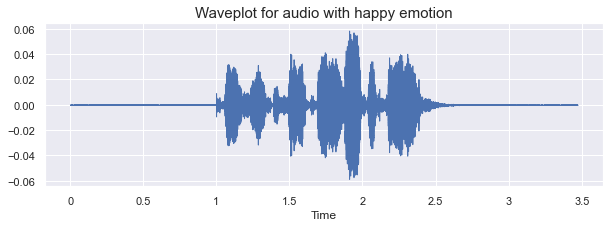

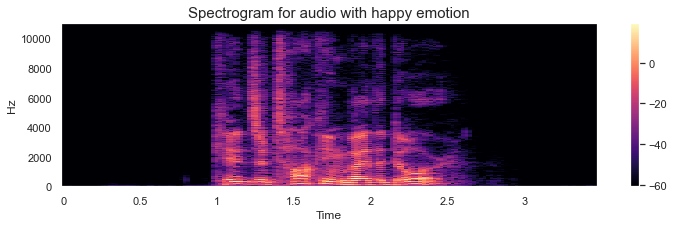

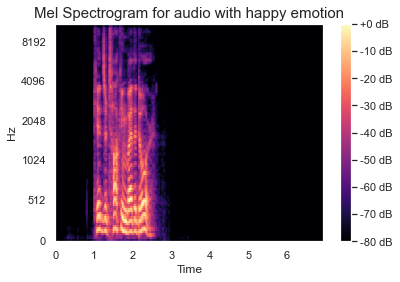

In [5]:
emotion = 'happy'
path = np.array(data_df.Path[data_df.Emotions == emotion])[0]
display_waveplot(path, emotion)
display_spectrogram(path, emotion)
display_melspectrogram(path, emotion)

## Getting features and labels

Features are in the shape of (50,) and include:
1. Zero Crossing Rate (1,)
2. Root Mean Square (1,)
3. Spectral Centroid (1,)
4. Spectral Rolloff (1,)
5. Spectral Bandwidth (1,)
6. Chroma (12,)
7. MFCC (33,)

In [6]:
if RESET:
    x, y = load_x_y(data_df, DATASET, save_dir='../data/melspectrogram/')
else:
    x = np.load(f'../data/melspectrogram/{DATASET}_features.npy')
    y = np.load(f'../data/melspectrogram/{DATASET}_labels.npy')

100%|██████████| 8116/8116 [07:00<00:00, 19.32it/s]


[array(['angry', 'happy', 'neutral', 'sad'], dtype=object)]


In [7]:
print("Features:", x.shape)
print("Labels:", y.shape)

Features: (8116, 128, 300, 1)
Labels: (8116, 4)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2,
    stratify=y,
    random_state=0
)

print("Train X shape:", x_train.shape)
print("Test X shape:", x_test.shape)

print("Train Y shape:", y_train.shape)
print("Test Y shape:", y_test.shape)

Train X shape: (6492, 128, 300, 1)
Test X shape: (1624, 128, 300, 1)
Train Y shape: (6492, 4)
Test Y shape: (1624, 4)


## Train Model

In [9]:
model = build_model(shape=x_train[0].shape, classes=y.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 298, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 149, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 147, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 71, 64)        1

In [10]:
early_stopping_monitor = EarlyStopping(
    monitor='loss', patience=2
)

history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping_monitor]
)

Epoch 1/50
406/406 [==============================] - 13s 18ms/step - loss: 1.9441 - accuracy: 0.3273
Epoch 2/50
406/406 [==============================] - 7s 17ms/step - loss: 0.9384 - accuracy: 0.5929
Epoch 3/50
406/406 [==============================] - 7s 17ms/step - loss: 0.7919 - accuracy: 0.6600
Epoch 4/50
406/406 [==============================] - 7s 17ms/step - loss: 0.7062 - accuracy: 0.7039
Epoch 5/50
406/406 [==============================] - 7s 17ms/step - loss: 0.6501 - accuracy: 0.7292
Epoch 6/50
406/406 [==============================] - 7s 17ms/step - loss: 0.5811 - accuracy: 0.7629
Epoch 7/50
406/406 [==============================] - 7s 17ms/step - loss: 0.5558 - accuracy: 0.7742
Epoch 8/50
406/406 [==============================] - 7s 17ms/step - loss: 0.5033 - accuracy: 0.7954
Epoch 9/50
406/406 [==============================] - 7s 17ms/step - loss: 0.4834 - accuracy: 0.8036
Epoch 10/50
406/406 [==============================] - 7s 17ms/step - loss: 0.4580 - accur

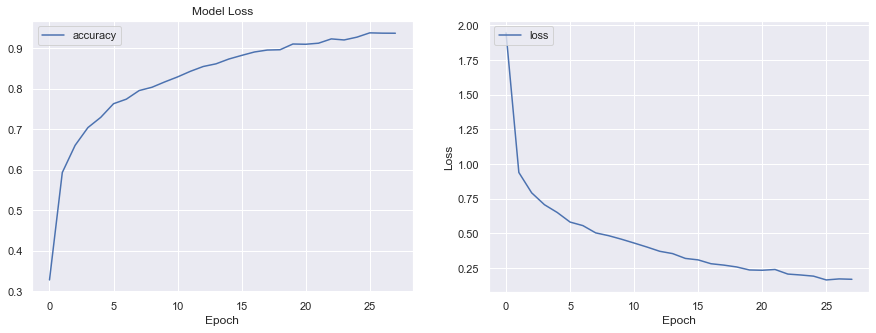

In [11]:
display_model_history(history.history, val=False)

## Evaluate Model

In [13]:
a1, l1 = model.evaluate(x_test, y_test, verbose=0)
a2, l2 = model.evaluate(x_train, y_train, verbose=0)
a3, l3 = model.evaluate(x, y, verbose=0)
print(
    """
    Test Loss: {:.4f}
    Test Accuracy: {:.4f}

    Train Loss: {:.4f}
    Train Accuracy: {:.4f}

    Full Dataset Loss: {:.4f}
    Full Dataset Accuracy: {:.4f}

    """.format(a1, l1, a2, l2, a3, l3)
)


    Test Loss: 0.7917
    Test Accuracy: 0.7672

    Train Loss: 0.0407
    Train Accuracy: 0.9941

    Full Dataset Loss: 0.1910
    Full Dataset Accuracy: 0.9487

    


In [14]:
model.save(f'{DATASET}_model_4.h5')

In [15]:
ex = np.array([
    extract_melspectrogram('../examples/sad.wav'),
    extract_melspectrogram('../examples/angry1.wav'),
])
ex.shape

(2, 128, 300)

In [16]:
labs = pd.read_json("../data/melspectrogram/labels.json", orient='index').to_dict()[0]
print(labs)

preds = model.predict(ex)
print(preds)

print(
    "\npredicted:", labs[np.argmax(preds[0])],
    "\nactual:", 'sad'
)
print(
    "\npredicted:", labs[np.argmax(preds[1])],
    "\nactual:", 'angry'
)


{0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}
[[8.7017303e-12 2.3342942e-07 1.5947282e-07 9.9999964e-01]
 [2.5079691e-01 1.9403065e-04 1.0633214e-02 7.3837584e-01]]

predicted: sad 
actual: sad

predicted: sad 
actual: angry
